## Introduction to Compressed Sensing

### Simple problem

$x$ is a $3$-sparse vector of size $100$ and $A$ is a random binary sampling matrix of size $M \times N$. Given $y = Ax$, we estimate $x$ with 

$$\hat{x} = \arg\min_x \| y - Ax \|_2^2 + \gamma \| x \|_1$$

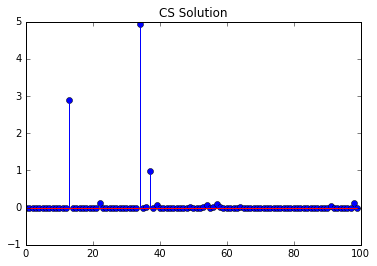

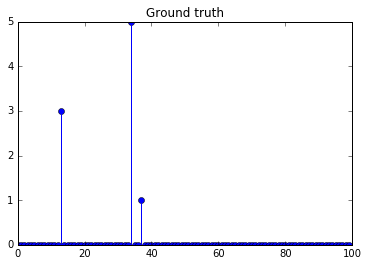

In [2]:
import numpy as np
from cvxpy import *
import matplotlib.pyplot as plt
%matplotlib inline

M = 30
N = 100

#define a sparse vector
x = np.zeros(N)
x[13] = 3
x[34] = 5
x[37] = 1

#define a random matrix
A = np.random.randint(0,2, [M, N])

#compute y
y = np.dot(A, x)

#add noise (comment it if you want the noiseless case)
sigma = 0.5
y += sigma*np.random.random(M)

# gamma must be positive due to DCP rules.
gamma = 1

# Construct the problem.
x_hat = Variable(N)
error = sum_squares(A*x_hat - y)
obj = Minimize(error + gamma*norm(x_hat, 1))
prob = Problem(obj)

prob.solve()

#plot solution
plt.figure()
plt.stem(x_hat.value)
plt.title('CS Solution')
plt.show()

#plot ground truth
plt.figure()
plt.stem(x)
plt.title('Ground truth')
plt.show()

### Sparsity in the wavelet domain

Often, the vector $x$ is not sparse in the primal domain, but could be sparse in a different domain. For instance, it is well-known that images are spare in the wavelet domain.

$$x = W^T \alpha$$

where $W$ is an orthonormal basis containing the wavelet basis functions and $\alpha$ is the sparse vector of wavelet coefficients.

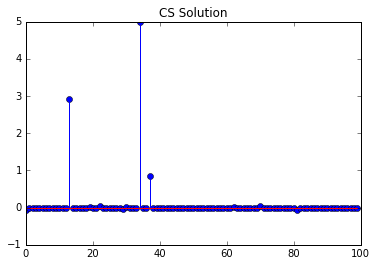

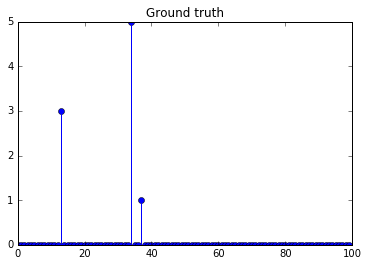

In [3]:
import scipy as sp

M = 30
N = 100

#define a sparse vector
alpha = np.zeros(N)
alpha[13] = 3
alpha[34] = 5
alpha[37] = 1

#generate a random orthonormal matrix
W = sp.linalg.orth(np.random.random([N,N]))

#define a random sampling matrix
A = np.random.randint(0,2, [M, N])
B = np.dot(A, W)

#compute y = AWalpha
y = np.dot(B, alpha)

#add noise (comment it if you want the noiseless case)
sigma = 0.5
y += sigma*np.random.random(M)

# gamma must be positive due to DCP rules.
gamma = 1

# Construct the problem.
alpha_hat = Variable(N)
error = sum_squares(B*alpha_hat - y)
obj = Minimize(error + gamma*norm(alpha_hat, 1))
prob = Problem(obj)

prob.solve()

#plot solution
plt.figure()
plt.stem(alpha_hat.value)
plt.title('CS Solution')
plt.show()

#plot ground truth
plt.figure()
plt.stem(alpha)
plt.title('Ground truth')
plt.show()


## TV norm experiments

In [4]:
def upsample(s, n, phase=0):
    """Increase sampling rate by integer factor n  with included offset phase.
    """
    return np.roll(np.kron(s, np.r_[1, np.zeros(n-1)]), phase)

(8000, 8000)
(8000,)
(1600, 5)
(8000, 1)


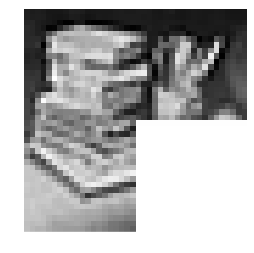

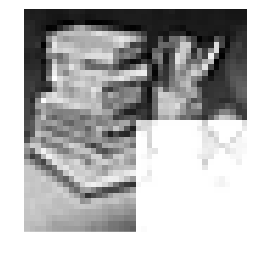

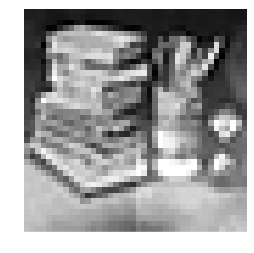

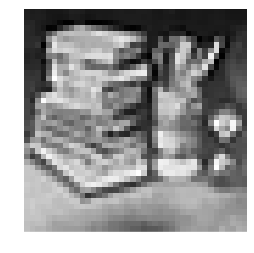

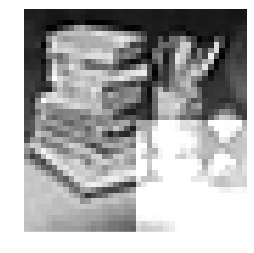

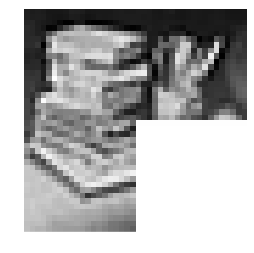

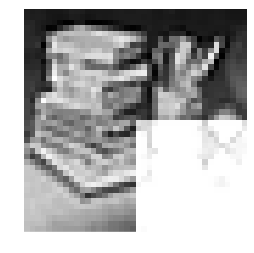

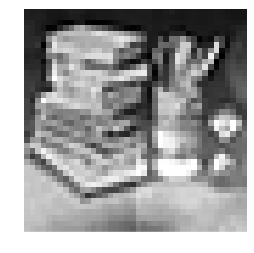

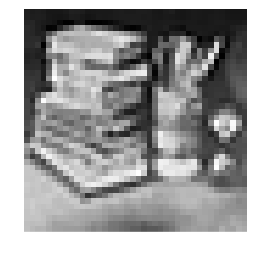

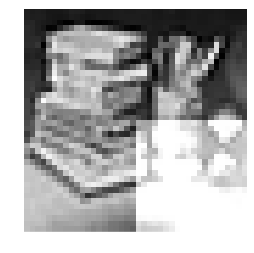

In [195]:
from skimage import io
from skimage import color

K = 5
N = 40
phi = 0.0   #shift due to the light

diffuse = io.imread('images/original_40_40.png')
diffuse = color.rgb2gray(diffuse)

specular = np.zeros([N,N])
specular[20:, 20:] = 1

shifts = np.linspace(0, np.pi-np.pi/4, K)

images = np.zeros([N, N, K])

for k, shift in enumerate(shifts):
    
    #make sure we clip the specularity and maintain the same exposure level
    image = np.minimum(diffuse + specular*(np.cos(phi+shift))**2, 1)
    images[:,:,k] = image
    
    plt.figure()
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.axis('off');
        
A = []
identity = np.eye(K*N*N)
#identity = identity[::K]

for k in range(K):
    if len(A) == 0:
        A = identity[::K]
    else:
        A = np.vstack([A, identity[k::K]])
        
print(A.shape)

x = np.reshape(images, [N*N,K])

#measurements
y = np.dot(A, images.flatten())

print(y.shape)
print(x.shape)

# gamma must be positive due to DCP rules.
gamma = 1000

# Construct the problem.
#x_hat = Variable(N*N, K)
#obj = Minimize(tv(reshape(x_hat[:,0], N,N), reshape(x_hat[:,1], N,N), reshape(x_hat[:,2], N,N), reshape(x_hat[:,3], N,N)) )
#constraints = [A*vec(x_hat) == y]

#prob = Problem(obj)
#prob = Problem(obj, constraints)
#prob.solve(verbose=False, solver=SCS)

x_hat = Variable(N*N*K)
#obj = Minimize(tv(reshape(x_hat, K, N*N)) + gamma*sum_squares(A*x_hat - y) )
obj = Minimize(tv(x_hat) + gamma*sum_squares(A*x_hat - y) )
#obj = Minimize(tv(x_hat))
#obj = Minimize(tv(reshape(x_hat, K*N, N)) )
#constraints = [A*vec(x_hat) == y]

#prob = Problem(obj, constraints)
prob = Problem(obj)
prob.solve(verbose=False, solver=SCS)


print(x_hat.value.shape)
x_hat = np.array(x_hat.value)

x_hat_3D = x_hat.reshape((N,N,K))
for k in range(K):
    image = x_hat_3D[:,:,k]
    
    plt.figure()
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.axis('off');



In [224]:
def haar(n):
    h = [1]
    if n > 2:
        h = haar(n/2)

    #calculate upper haar part
    h_n = np.kron(h, [1,1])
    
    #calculate lower haar part
    if len(h) < 2:
        h_i = np.kron([1], [1,-1]) 
    else:
        h_i = np.kron(np.eye(len(h)), [1,-1]) 
    
    #combine parts
    h = np.vstack([h_n, h_i])
    return h/np.sqrt(2)

def sampling_matrix(N, K):
    A = []
    identity = np.eye(K*N*N)
    #identity = identity[::K]

    for k in range(K):
        if len(A) == 0:
            A = identity[::K]
        else:
            A = np.vstack([A, identity[k::K]])
        
    return A

def generate_images(path, N, K, phi, display=False):
    
    diffuse = io.imread(path)
    diffuse = color.rgb2gray(diffuse)

    specular = np.zeros([N,N])
    specular[N//2:, N//2:] = 1

    shifts = np.linspace(0, np.pi-np.pi/4, K)

    images = np.zeros([K, N, N])

    for k, shift in enumerate(shifts):

        #make sure we clip the specularity and maintain the same exposure level
        image = np.minimum(diffuse + specular*(np.cos(phi+shift))**2, 1)
        images[k,:,:] = image
        
        if display:
            plt.figure()
            plt.imshow(image, cmap='gray', interpolation='none')
            plt.axis('off');
        
    return images, diffuse, specular

def generate_images_from_alpha(N, K, phi, alpha_d, alpha_s, W, display=False):
    
    diffuse  = np.dot(W, alpha_d).reshape([N, N])
    specular = np.dot(W, alpha_s).reshape([N, N])

    shifts = np.linspace(0, np.pi-np.pi/4, K)
    images = np.zeros([K, N, N])

    for k, shift in enumerate(shifts):

        #make sure we clip the specularity and maintain the same exposure level
        image = np.minimum(diffuse + specular*(np.cos(phi+shift))**2, 1)
        images[k,:,:] = image
        
        if display:
            plt.figure()
            plt.imshow(image, cmap='gray', interpolation='none')
            plt.axis('off');
        
    return images, diffuse, specular

def compute_C(N, K, phi):
    
    shifts = np.linspace(0, np.pi-np.pi/4, K)
    
    C = []
    for k, shift in enumerate(shifts):
        if len(C) == 0:
            C = np.hstack([ np.eye(N**2), np.cos(phi+shift)**2*np.eye(N**2) ])
        else:
            Cnew = np.hstack([ np.eye(N**2), np.cos(phi+shift)**2*np.eye(N**2) ])
            C    = np.vstack([C, Cnew])
            
    return C
                
print(haar(8))

[[ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
   0.35355339  0.35355339]
 [ 0.35355339  0.35355339  0.35355339  0.35355339 -0.35355339 -0.35355339
  -0.35355339 -0.35355339]
 [ 0.5         0.5        -0.5        -0.5         0.          0.         -0.
  -0.        ]
 [ 0.          0.         -0.         -0.          0.5         0.5        -0.5
  -0.5       ]
 [ 0.70710678 -0.70710678  0.         -0.          0.         -0.          0.
  -0.        ]
 [ 0.         -0.          0.70710678 -0.70710678  0.         -0.          0.
  -0.        ]
 [ 0.         -0.          0.         -0.          0.70710678 -0.70710678
   0.         -0.        ]
 [ 0.         -0.          0.         -0.          0.         -0.
   0.70710678 -0.70710678]]


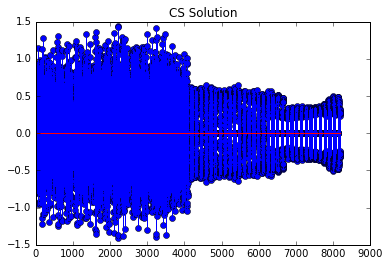

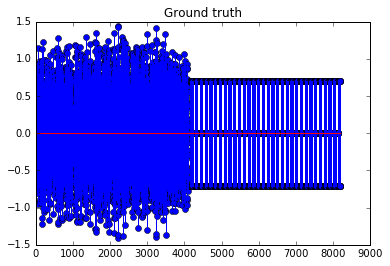

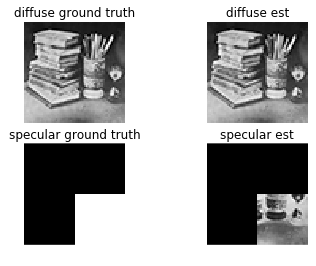

In [233]:
import scipy as sp

K  = 4
N  = 64
N2 = N**2
phi = 0.0

#generate a Haar matrix
W = haar(N2)

#define the sampling matrix
A = sampling_matrix(N, K)
#B = np.dot(A, np.tile(W, [K ,1]))
B = np.dot(A, np.kron(np.eye(K), W))

#compute y = A*x
images, diffuse, spec = generate_images('images/original_64_64.png', N, K, phi)
x       = images.flatten()
alpha_d = np.dot(W.T, diffuse.flatten())
alpha_s = np.dot(W.T, spec.flatten())

#make sure we are sparse in the wavelet domain
#alpha_d = np.zeros(N2)
#alpha_s = np.zeros(N2)

#alpha_d[12] = 2
#alpha_d[120] = 4
#alpha_d[587] = 0.5
#alpha_d[286] = 6
#alpha_s[121] = 3
#alpha_s[985] = 5
#alpha_s[101] = 1

#images, diffuse, spec = generate_images_from_alpha(N, K, phi, alpha_d, alpha_s, W)

alpha = np.hstack([alpha_d, alpha_s])

#measurements
y = np.dot(A, x)

#model matrix
C = compute_C(N, K, phi)
S = np.dot(B, C)

#add noise (comment it if you want the noiseless case)
#sigma = 0.1
#y += sigma*np.random.random(len(y))

# gamma must be positive
gamma = 0.1

# Construct the problem
alpha_hat = Variable(2*N2)
error = sum_squares(S*alpha_hat - y)
obj = Minimize(error + gamma*norm(alpha_hat, 1))
obj = Minimize(error)
prob = Problem(obj)

prob.solve(solver=SCS)

#plot solution
plt.figure()
plt.stem(alpha_hat.value)
plt.title('CS Solution')
plt.show()

#plot ground truth
plt.figure()
plt.stem(alpha) 
plt.title('Ground truth')
plt.show()

diffuse_hat = np.reshape(np.dot(W, alpha_hat.value[:N2]), [N, N])
spec_hat = np.reshape(np.dot(W, alpha_hat.value[N2:]), [N, N])

#plot all the images 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.imshow(diffuse, cmap='gray', interpolation='none')
ax1.axis('off')
ax1.set_title('diffuse ground truth')

ax2.imshow(diffuse, cmap='gray', interpolation='none')
#ax2.imshow(y.reshape([K,N,N])[1,:,:], cmap='gray', interpolation='none')
ax2.axis('off');
ax2.set_title('diffuse est')

ax3.imshow(spec, cmap='gray', interpolation='none')
ax3.axis('off');
ax3.set_title('specular ground truth')

ax4.imshow(spec_hat, cmap='gray', interpolation='none')
ax4.axis('off');
ax4.set_title('specular est')


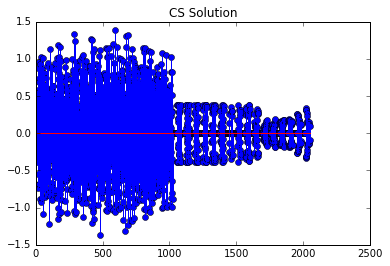

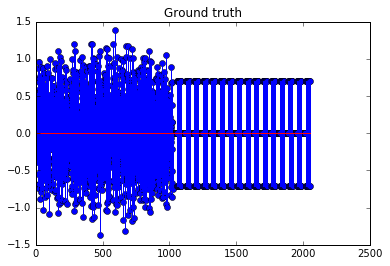

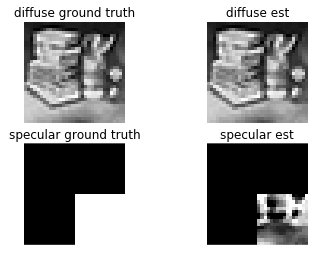

In [234]:
import scipy as sp

K  = 4
N  = 32
N2 = N**2
phi = 0.5

#generate a Haar matrix
W = haar(N2)

#define the sampling matrix
A = sampling_matrix(N, K)
#B = np.dot(A, np.tile(W, [K ,1]))
B = np.dot(A, np.kron(np.eye(K), W))

#compute y = A*x
images, diffuse, spec = generate_images('images/original_32_32.png', N, K, phi)
x       = images.flatten()
alpha_d = np.dot(W.T, diffuse.flatten())
alpha_s = np.dot(W.T, spec.flatten())

#make sure we are sparse in the wavelet domain
#alpha_d = np.zeros(N2)
#alpha_s = np.zeros(N2)

#alpha_d[12] = 2
#alpha_d[120] = 4
#alpha_d[587] = 0.5
#alpha_d[286] = 6
#alpha_s[121] = 3
#alpha_s[985] = 5
#alpha_s[101] = 1

#images, diffuse, spec = generate_images_from_alpha(N, K, phi, alpha_d, alpha_s, W)

alpha = np.hstack([alpha_d, alpha_s])

#measurements
y = np.dot(A, x)

#model matrix
C = compute_C(N, K, 0)
S = np.dot(B, C)

#add noise (comment it if you want the noiseless case)
sigma = 0.0
y += sigma*np.random.random(len(y))

# gamma must be positive
gamma = 1

# Construct the problem
alpha_hat = Variable(2*N2)
error = sum_squares(S*alpha_hat - y)
obj = Minimize(error + gamma*norm(alpha_hat, 1))
obj = Minimize(error)
prob = Problem(obj)

prob.solve(solver=SCS)

#plot solution
plt.figure()
plt.stem(alpha_hat.value)
plt.title('CS Solution')
plt.show()

#plot ground truth
plt.figure()
plt.stem(alpha) 
plt.title('Ground truth')
plt.show()

diffuse_hat = np.reshape(np.dot(W, alpha_hat.value[:N2]), [N, N])
spec_hat = np.reshape(np.dot(W, alpha_hat.value[N2:]), [N, N])

#plot all the images 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.imshow(diffuse, cmap='gray', interpolation='none')
ax1.axis('off')
ax1.set_title('diffuse ground truth')

ax2.imshow(diffuse, cmap='gray', interpolation='none')
#ax2.imshow(y.reshape([K,N,N])[1,:,:], cmap='gray', interpolation='none')
ax2.axis('off');
ax2.set_title('diffuse est')

ax3.imshow(spec, cmap='gray', interpolation='none')
ax3.axis('off');
ax3.set_title('specular ground truth')

ax4.imshow(spec_hat, cmap='gray', interpolation='none')
ax4.axis('off');
ax4.set_title('specular est')


(1024, 4096)
(1024, 4096)
(4096, 2048)
(1024,)
(2048, 1)
(32, 32, 4)


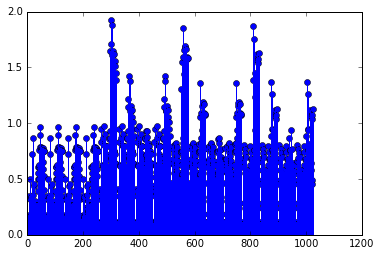

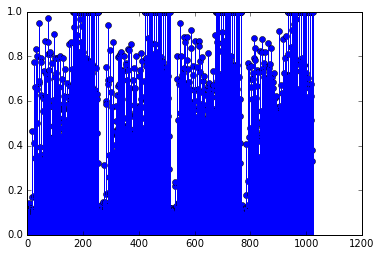

In [174]:
print(B.shape)
print(A.shape)
print(C.shape)
print(alpha_d.shape)
print(alpha_hat.value.shape)

print(images[:N2].shape)

plt.stem(np.dot(S, alpha))
plt.show();
plt.stem(y)
plt.show();

In [ ]:
import pywt

M = 30
N = 100

#define a sparse vector
alpha = np.zeros(N)
alpha[13] = 3
alpha[34] = 5
alpha[37] = 1

#compute the wavelet matrix
w_type = 'db2'
w_level = 4

W = np.array([])
W_rec = np.array([])

for n in range(N):
    vec = np.zeros(N)
    vec[n] = 1
    coeffs = pywt.wavedec(vec, w_type, level=w_level)
    #flatten the coefficients
    coeffs = np.array([item for sublist in coeffs for item in sublist])
    
    #stack the vectors in the matrix W
    if len(W) == 0:
        W = coeffs
    else:
        W = np.vstack([W, coeffs])
    
    #reconstruction coefficients
    coeffs_rec = pywt.waverec(vec, w_type, level=w_level)
    #flatten the coefficients
    coeffs_rec = np.array([item for sublist in coeffs_rec for item in sublist])
    
    #stack the vectors in the matrix W
    if len(W_rec) == 0:
        W_rec = coeffs_rec
    else:
        W_rec = np.vstack([W_rec, coeffs_rec])

print(W.shape)
    
#define a random sampling matrix
A = np.random.randint(0,2, [M, N])



#compute y
y = np.dot(A, x)

#add noise (comment it if you want the noiseless case)
sigma = 0.5
y += sigma*np.random.random(M)

# gamma must be positive due to DCP rules.
gamma = 1

# Construct the problem.
x_hat = Variable(N)
error = sum_squares(A*x_hat - y)
obj = Minimize(error + gamma*norm(x_hat, 1))
prob = Problem(obj)


